In [1]:
import re
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from Common.functions import evaluate_model, train_model
from Common.custom_dataset import CustomDataset
from Common.ffnn import FFNN
from Common.rnn import RNN


[nltk_data] Downloading package punkt to /Users/ali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'Common'

### Import Dataset

In [16]:
# Load the train set
train_data = pd.read_csv("../Data/arxiv_train.csv")
print("\nShape of X_train:", train_data.shape)
print(f"\n{train_data.head(5)}")


Shape of X_train: (80000, 3)

   Unnamed: 0                                           abstract     label
0       31716    Automatic meeting analysis is an essential f...      eess
1       89533    We propose a protocol to encode classical bi...  quant-ph
2       82700    A number of physically intuitive results for...  quant-ph
3       78830    In the last decade rare-earth hexaborides ha...   physics
4       94948    We introduce the weak barycenter of a family...      stat


In [17]:
# Load the train set
test_data = pd.read_csv("../Data/arxiv_test.csv")
print("Shape of X_test:", test_data.shape)
print(f"\n{test_data.head(5)}")

Shape of X_test: (20000, 3)

   Unnamed: 0                                           abstract   label
0       64481    We describe a shape derivative approach to p...    math
1       48104    We study displaced signatures of sneutrino p...  hep-ph
2       48233    High precision studies of Beyond-Standard-Mo...  hep-ph
3       49026    We find that a class of models of MeV-GeV da...  hep-ph
4       37957    Knowledge of power grid's topology during ca...    eess


### Data Cleaning

In [18]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text.lower())  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()  # Lemmatize each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stemmer = PorterStemmer()  # Stem each word
    tokens = [stemmer.stem(word) for word in tokens]
    clean_text = ' '.join(tokens)  # Join tokens back into a single string
    return clean_text

train_data['clean_abstract'] = train_data['abstract'].apply(clean_text)
test_data['clean_abstract'] = test_data['abstract'].apply(clean_text)


In [19]:
# Print out the 10 fields of research
fields_of_research = train_data['label'].unique()
for field in fields_of_research:
    print(field)

eess
quant-ph
physics
stat
math
astro-ph
cond-mat
hep-th
cs
hep-ph


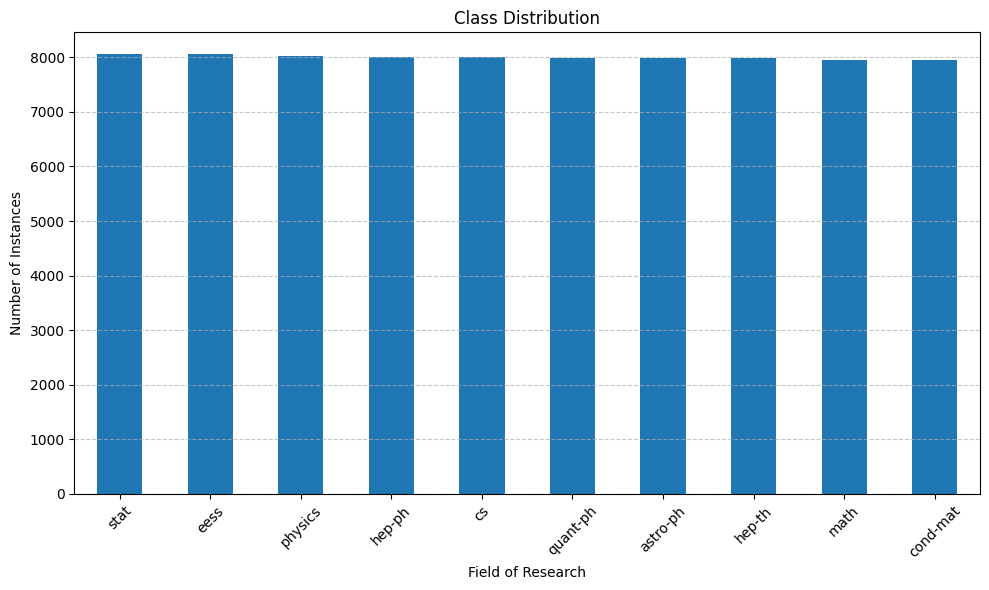

In [20]:
# Calculate class distribution
class_distribution = train_data['label'].value_counts()

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Field of Research')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

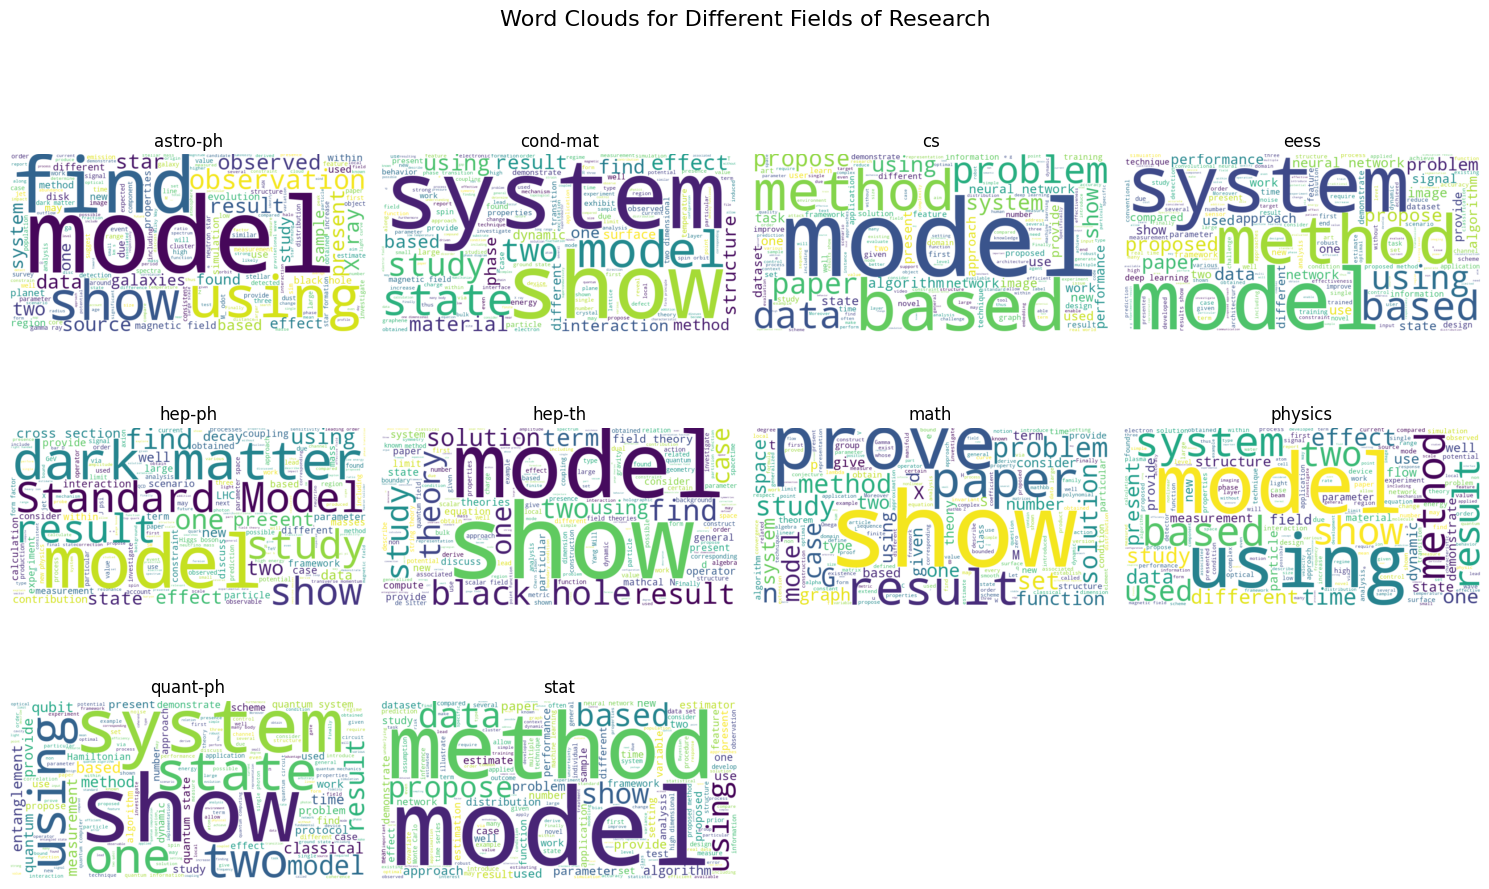

In [21]:
# Concatenate abstracts based on class labels
abstracts_by_class = {}
for label, group in train_data.groupby('label'):
    abstracts_by_class[label] = ' '.join(group['abstract'])

# Generate and plot word clouds for each class
plt.figure(figsize=(15, 10))
for i, (label, abstracts) in enumerate(abstracts_by_class.items(), start=1):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(abstracts)
    plt.subplot(3, 4, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label)
    plt.axis('off')
plt.suptitle('Word Clouds for Different Fields of Research', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


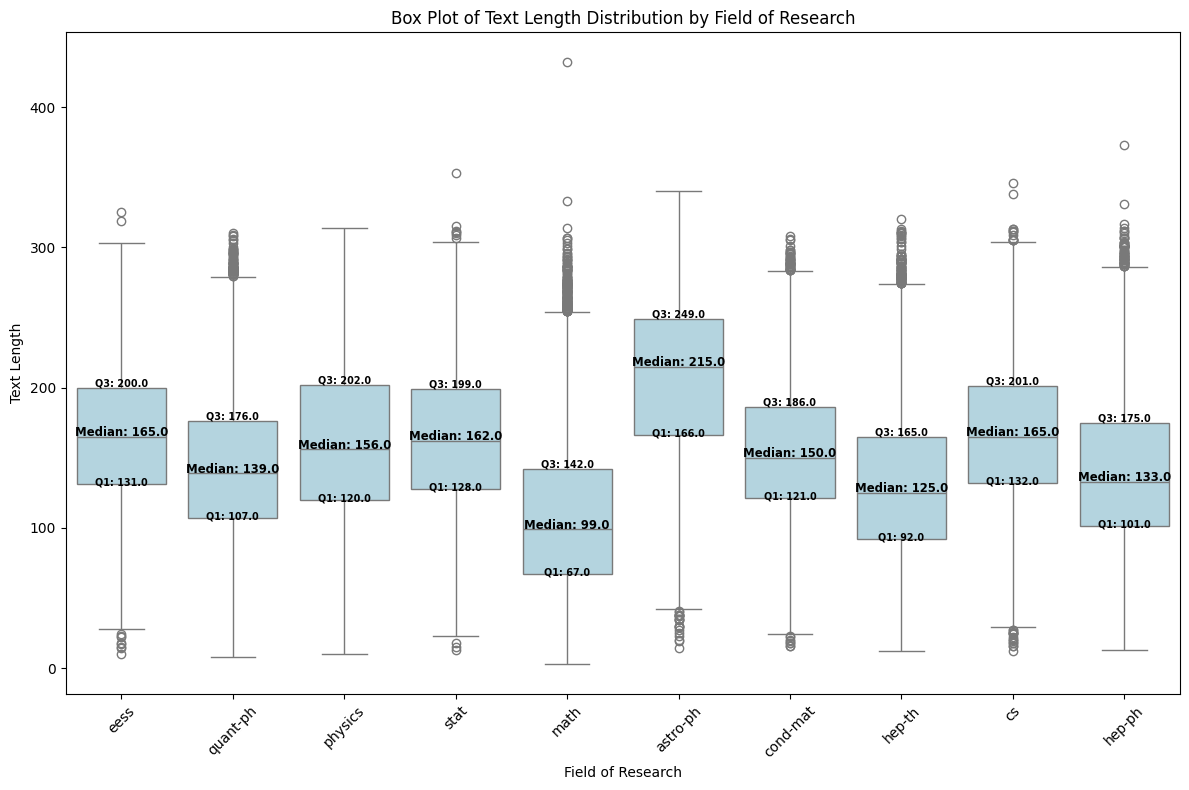

In [22]:
# Calculate text lengths if not already calculated
if 'text_length' not in train_data.columns:
    train_data['text_length'] = train_data['abstract'].apply(lambda x: len(x.split()))

# Calculate medians and quartiles if not already calculated
if 'medians' not in locals() or 'quartiles' not in locals():
    medians = train_data.groupby('label')['text_length'].median()
    quartiles = train_data.groupby('label')['text_length'].quantile([0.25, 0.75]).unstack(level=1)

# Plotting Box Plot
plt.figure(figsize=(12, 8))
box = sns.boxplot(data=train_data, x='label', y='text_length', color='lightblue')
plt.xticks(rotation=45)  # Helps if labels overlap or are too long

# Annotate with median, Q1, and Q3 values
labels = train_data['label'].unique()
for i, label in enumerate(labels):
    median = medians.loc[label]
    q1 = quartiles.loc[label][0.25]
    q3 = quartiles.loc[label][0.75]

    # Display median
    box.text(i, median + 0.5, f'Median: {median}', horizontalalignment='center', size='small', color='black', weight='semibold')
    
    # Display Q1
    box.text(i, q1 - 1, f'Q1: {q1}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    
    # Display Q3
    box.text(i, q3 + 1, f'Q3: {q3}', horizontalalignment='center', size='x-small', color='black', weight='semibold')

plt.title('Box Plot of Text Length Distribution by Field of Research')
plt.xlabel('Field of Research')
plt.ylabel('Text Length')
plt.tight_layout()
plt.show()

In [23]:
# Define the bags-of-words representations
count_vectorizer = CountVectorizer(max_features=5000)  # Adjust max_features as needed
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed


In [24]:
# Convert abstracts into feature vectors
X_train_count = count_vectorizer.fit_transform(train_data['clean_abstract']).toarray()
X_test_count = count_vectorizer.transform(test_data['clean_abstract']).toarray()

In [25]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_abstract']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_abstract']).toarray()


In [26]:
# Define the labels
label_encoder = {label: idx for idx, label in enumerate(train_data['label'].unique())}
train_data['label_encoded'] = train_data['label'].map(label_encoder)
test_data['label_encoded'] = test_data['label'].map(label_encoder)

In [27]:
# Convert labels to PyTorch tensors
y_train = torch.tensor(train_data['label_encoded'].values)
y_test = torch.tensor(test_data['label_encoded'].values)


In [29]:
# Define train and test datasets
train_dataset_count = CustomDataset(X_train_count, y_train)
test_dataset_count = CustomDataset(X_test_count, y_test)

train_dataset_tfidf = CustomDataset(X_train_tfidf, y_train)
test_dataset_tfidf = CustomDataset(X_test_tfidf, y_test)

# Define data loaders
train_loader_count = DataLoader(train_dataset_count, batch_size=64, shuffle=True)
test_loader_count = DataLoader(test_dataset_count, batch_size=64, shuffle=False)

train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=64, shuffle=True)
test_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=64, shuffle=False)


In [30]:
# Train and evaluate FFNN with CountVectorizer and different numbers of layers
input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
for num_layers in [1, 2, 3]:
    print(f"Training FFNN with CountVectorizer and {num_layers} layers\n")
    
    ffnn_count = FFNN(input_size_count, 256, output_size_count, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(ffnn_count.parameters(), lr=0.001)
    
    train_model(ffnn_count, criterion, optimizer, train_loader_count, num_epochs=10)
    evaluate_model(ffnn_count, test_loader_count)

Training FFNN with CountVectorizer and 1 layers

Epoch [1/10], Loss: 1487.622189104557
Epoch [2/10], Loss: 676.3006291091442
Epoch [3/10], Loss: 571.7156626135111
Epoch [4/10], Loss: 515.1160263717175
Epoch [5/10], Loss: 476.7579248547554
Epoch [6/10], Loss: 448.8227161318064
Epoch [7/10], Loss: 427.3187493830919
Epoch [8/10], Loss: 409.2923297435045
Epoch [9/10], Loss: 394.5060997977853
Epoch [10/10], Loss: 381.60735034942627

Evaluations:
Accuracy: 81.19%
F1 Score: 81.08%
Precision: 81.08%
Recall: 81.13%


Training FFNN with CountVectorizer and 2 layers

Epoch [1/10], Loss: 1023.7436028420925
Epoch [2/10], Loss: 733.9210453927517
Epoch [3/10], Loss: 568.5260360389948
Epoch [4/10], Loss: 431.52026928961277
Epoch [5/10], Loss: 348.19548942893744
Epoch [6/10], Loss: 314.76668387278914
Epoch [7/10], Loss: 304.3224899508059
Epoch [8/10], Loss: 305.9659097744152
Epoch [9/10], Loss: 309.95105675049126
Epoch [10/10], Loss: 302.80780893936753

Evaluations:
Accuracy: 72.58%
F1 Score: 69.86%
Pr

In [45]:
# Train and evaluate FFNN with TF-IDF and different numbers of layers
input_size_tfidf = X_train_tfidf.shape[1]
output_size_tfidf = len(label_encoder)
for num_layers in [1, 2, 3]:
    print(f"Training FFNN with TF-IDF and {num_layers} layers\n")
    
    ffnn_tfidf = FFNN(input_size_tfidf, 256, output_size_tfidf, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(ffnn_tfidf.parameters(), lr=0.001)
    
    train_model(ffnn_tfidf, criterion, optimizer, train_loader_tfidf, num_epochs=10)
    evaluate_model(ffnn_tfidf, test_loader_tfidf)

Training FFNN with TF-IDF and 1 layers
Epoch [1/10], Loss: 804.047559350729
Epoch [2/10], Loss: 491.7932781726122
Epoch [3/10], Loss: 417.528767041862
Epoch [4/10], Loss: 359.0492602214217
Epoch [5/10], Loss: 300.96927104890347
Epoch [6/10], Loss: 241.88520386442542
Epoch [7/10], Loss: 183.45485566183925
Epoch [8/10], Loss: 129.9221566990018
Epoch [9/10], Loss: 84.81591106764972
Epoch [10/10], Loss: 51.366560698486865
Evaluation on Test Set:
FFNN Model
Accuracy: 81.08%
F1 Score: 80.95%
Precision: 80.92%
Recall: 81.03%


Training FFNN with TF-IDF and 2 layers
Epoch [1/10], Loss: 766.8044961690903
Epoch [2/10], Loss: 482.829276278615
Epoch [3/10], Loss: 380.1385106742382
Epoch [4/10], Loss: 269.68803653493524
Epoch [5/10], Loss: 152.9423440657556
Epoch [6/10], Loss: 62.45374880358577
Epoch [7/10], Loss: 22.420922095538117
Epoch [8/10], Loss: 9.1373335000535
Epoch [9/10], Loss: 12.101585005482775
Epoch [10/10], Loss: 15.20859732099052
Evaluation on Test Set:
FFNN Model
Accuracy: 80.71%
F1

In [24]:
# Train and evaluate RNN with CountVectorizer and different numbers of layers
for num_layers in [1, 2, 3]:
    print(f"Training RNN with CountVectorizer and {num_layers} layers\n")
    
    rnn_count = RNN(input_size_count, 256, output_size_count, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn_count.parameters(), lr=0.001)
    
    train_model(rnn_count, criterion, optimizer, train_loader_count, num_epochs=10)
    evaluate_model(rnn_count, test_loader_count)

Training RNN with CountVectorizer and 1 layers
Epoch [1/10], Loss: 764.3558000475168
Epoch [2/10], Loss: 522.6995288431644
Epoch [3/10], Loss: 425.54208475351334
Epoch [4/10], Loss: 342.77462404966354
Epoch [5/10], Loss: 267.67707454785705
Epoch [6/10], Loss: 197.6573838032782
Epoch [7/10], Loss: 136.99245755933225
Epoch [8/10], Loss: 94.9644560823217
Epoch [9/10], Loss: 64.10324719455093
Epoch [10/10], Loss: 46.58516047289595
Evaluation on Test Set:
Accuracy: 0.81015, Precision: 0.8113540156776645, Recall: 0.8099576366757107, F1-Score: 0.8086963061028177

Training RNN with CountVectorizer and 2 layers
Epoch [1/10], Loss: 778.2435877323151
Epoch [2/10], Loss: 547.3522815555334
Epoch [3/10], Loss: 469.0773104131222
Epoch [4/10], Loss: 406.9993548542261
Epoch [5/10], Loss: 353.33334842324257
Epoch [6/10], Loss: 299.4176407828927
Epoch [7/10], Loss: 248.53780087828636
Epoch [8/10], Loss: 200.20783401466906
Epoch [9/10], Loss: 159.4551033070311
Epoch [10/10], Loss: 128.90036467369646
Evalu

In [28]:
# Train and evaluate RNN with TF-IDF and different numbers of layers
for num_layers in [1, 2, 3]:
    print(f"Training RNN with TF-IDF and {num_layers} layers\n")
    
    rnn_count = RNN(input_size_tfidf, 256, output_size_tfidf, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn_count.parameters(), lr=0.001)
    
    train_model(rnn_count, criterion, optimizer, train_loader_count, num_epochs=10)
    evaluate_model(rnn_count, test_loader_count)

Training RNN with TF-IDF and 1 layers
Epoch [1/10], Loss: 763.7293433248997
Epoch [2/10], Loss: 521.2800157517195
Epoch [3/10], Loss: 426.50201128423214
Epoch [4/10], Loss: 343.07136638462543
Epoch [5/10], Loss: 266.14753133803606
Epoch [6/10], Loss: 193.55615939944983
Epoch [7/10], Loss: 135.5761227197945
Epoch [8/10], Loss: 90.76669615786523
Epoch [9/10], Loss: 62.69850590918213
Epoch [10/10], Loss: 48.14457421237603
Evaluation on Test Set:
Accuracy: 0.80725, Precision: 0.8075271870685696, Recall: 0.8066065596702161, F1-Score: 0.8069022976256506

Training RNN with TF-IDF and 2 layers
Epoch [1/10], Loss: 778.735121101141
Epoch [2/10], Loss: 545.4131872653961
Epoch [3/10], Loss: 467.59743367135525
Epoch [4/10], Loss: 408.2917661815882
Epoch [5/10], Loss: 354.2695578634739
Epoch [6/10], Loss: 303.2418758645654
Epoch [7/10], Loss: 248.71587415412068
Epoch [8/10], Loss: 202.82988084107637
Epoch [9/10], Loss: 165.66498363390565
Epoch [10/10], Loss: 127.11110422387719
Evaluation on Test Set